In [1]:
import tensorflow as tf
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.5.0


In [2]:
!git clone --depth 1 -b v2.5.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 958, done.
remote: Counting objects: 100% (958/958), done.
remote: Compressing objects: 100% (783/783), done.
remote: Total 958 (delta 247), reused 340 (delta 162), pack-reused 0
Receiving objects: 100% (958/958), 1.49 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (247/247), done.
Note: checking out '4f0e20f26d79610b7dbcf4c103dbd53c456a8348'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [3]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.1MB 5.8MB/s 
     |████████████████████████████████| 194kB 52.4MB/s 
     |████████████████████████████████| 15.7MB 194kB/s 
     |████████████████████████████████| 10.8MB 16.2MB/s 
     |████████████████████████████████| 296kB 44.5MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 28.5MB 112kB/s 
     |████████████████████████████████| 215kB 60.8MB/s 
     |████████████████████████████████| 3.9MB 39.7MB/s 
     |████████████████████████████████| 686kB 56.6MB/s 
     |████████████████████████████████| 358kB 29.5MB/s 
     |████████████████████████████████| 2.0MB 48.8MB/s 
     |████████████████████████████████| 10.3MB 26.9MB/s 
     |████████████████████████████████| 645kB 57.0MB/s 
     |████████████████████████████████| 37.2MB 85kB/s 
     |████████████████████████████████| 3.0MB 32.1MB/s 
     |████████████████████████████████| 51kB 6.5MB/s 
     |████████████████████████████████| 1.2MB 24.3

In [4]:
!pip install transformers #if needed.

     |████████████████████████████████| 2.5MB 4.2MB/s 
     |████████████████████████████████| 3.3MB 24.7MB/s 
     |████████████████████████████████| 901kB 41.2MB/s 


In [1]:
#after restart the runtime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [2]:
print("TF Version: ", tf.__version__)
print("Eager Mode: ", tf.executing_eagerly())
print("Hub Version: ", hub.__version__)
print("GPU is", "available." if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE.")

TF Version:  2.5.0
Eager Mode:  True
Hub Version:  0.12.0
GPU is NOT AVAILABLE.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#df = pd.read_csv('/content/gdrive/MyDrive/Data/new_tweets.csv')
df = pd.read_csv('/content/gdrive/MyDrive/Data/Merge_Dataset.csv')
#df = pd.read_csv('/content/gdrive/MyDrive/Data/numeric_lable.csv')
df.head()

,text,lable
0,i didnt feel humiliated,negative
1,i can go from feeling so hopeless to so damned...,negative
2,im grabbing a minute to post i feel greedy wrong,negative
3,i am ever feeling nostalgic about the fireplac...,positive
4,i am feeling grouchy,negative


In [6]:
df.shape

(21783, 2)

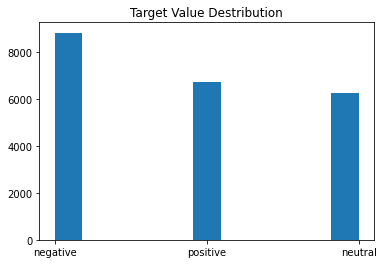

In [7]:
import matplotlib.pyplot as plt
plt.hist(df.lable, bins=11)
plt.title("Target Value Destribution")
plt.show()

In [8]:
class_to_index = dict((c, i) for i,c in enumerate(set(df.lable)))
index_to_class = dict((v, k) for k, v in class_to_index.items())
class_to_index

{'negative': 0, 'neutral': 2, 'positive': 1}

In [9]:
index_to_class

{0: 'negative', 1: 'positive', 2: 'neutral'}

In [10]:
df['lable'] = df.lable.replace(class_to_index)
df.head()

,text,lable
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,0


In [ ]:
#names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in df.lable])

In [ ]:
# train_df, remaining = train_test_split(df, random_state = 42, train_size = 0.8, stratify = df.lable.values)
# valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.2, stratify = remaining.lable.values)
# train_df.shape, valid_df.shape

In [11]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.lable.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.lable.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['lable', 'data_type']).count()

text
lable data_type      
0     train      7495
      val        1323
1     train      5713
      val        1008
2     train      5307
      val         937

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].lable.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].lable.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(class_to_index),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in class_to_index.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

KeyboardInterrupt: ignored

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(class_to_index),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)